In [2]:
# импорт библиотек
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder,LabelEncoder

# Предобработка

### Устранение пропусков 

In [3]:
train0 = pd.read_csv('train_bi/train_bi.csv')
train = train0.copy() # Будем хранить исходные данные в train0
test = pd.read_csv('train_bi/test_bi.csv')


In [4]:
train.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0


In [5]:
train.isna().sum()

id                      0
gender                  0
age                     0
hypertension            0
heart_disease           0
ever_married            0
work_type               0
Residence_type          0
avg_glucose_level       0
bmi                  1017
smoking_status       9176
stroke                  0
dtype: int64

In [6]:
train['smoking_status'].value_counts()

never smoked       11079
formerly smoked     5183
smokes              4563
Name: smoking_status, dtype: int64

In [7]:
# remove NaN
train['smoking_status']=train['smoking_status'].fillna('unknown');
test['smoking_status']=test['smoking_status'].fillna('unknown');

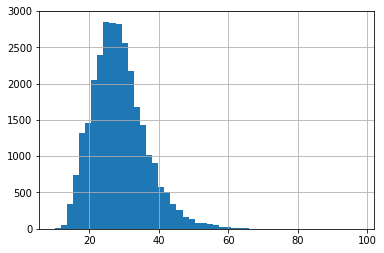

In [8]:
train['bmi'].hist(bins=50)

In [9]:
mean_bmi = train['bmi'].mean();
train['bmi'] = train['bmi'].fillna(mean_bmi);
mean_bmi = test['bmi'].mean();
test['bmi'] = test['bmi'].fillna(mean_bmi);

In [10]:
train.isna().sum()
test.isna().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
dtype: int64

### Перевод текстовых данных в численные с помощью map

In [11]:
train['gender']=train['gender'].replace({'Female':0,'Male':1,'Other':0})
train['ever_married']=train['ever_married'].replace({'No':0,'Yes':1})
train['Residence_type'] =train['Residence_type'].replace({'Urban':1,'Rural':0})
test['gender']=test['gender'].replace({'Female':0,'Male':1,'Other':0})
test['ever_married']=test['ever_married'].replace({'No':0,'Yes':1})
test['Residence_type'] =test['Residence_type'].replace({'Urban':1,'Rural':0})

features = ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', \
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', \
       'smoking_status']

In [12]:
train.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,1,3.0,0,0,0,children,0,95.12,18.0,unknown,0
1,30468,1,58.0,1,0,1,Private,1,87.96,39.2,never smoked,0
2,16523,0,8.0,0,0,0,Private,1,110.89,17.6,unknown,0
3,56543,0,70.0,0,0,1,Private,0,69.04,35.9,formerly smoked,0
4,46136,1,14.0,0,0,0,Never_worked,0,161.28,19.1,unknown,0


### Перевод smoking_status с помощью OneHotEncoder и LabelEncoder

In [13]:
train['smoking_status'].value_counts()

never smoked       11079
unknown             9176
formerly smoked     5183
smokes              4563
Name: smoking_status, dtype: int64

In [14]:
# При попытке использование OneHotEncoder сразу на текстовых данных интерпретатор выдает ошибку. После поиска 
# методов решения аналогичной проблемы другими программистами было выяснено, что OneHotEncoder работает
# только с числовыми данными. Поэтому перед его использования столбец был преобразован в числовой формат 
# с помощью LabelEncoder.
# Возможно, способность работы с текстом OneHotEncoder зависит от версии, этот вопрос я выяснять не стал. 
smoking_status_hot = OneHotEncoder(handle_unknown='ignore',sparse=int,dtype=int)
smoking_status_lab = LabelEncoder()
smoking_status_lab.fit(train['smoking_status'])
print(smoking_status_lab.classes_)
train['smoking_status'] = smoking_status_lab.transform(train['smoking_status'])
test['smoking_status'] = smoking_status_lab.transform(test['smoking_status'])
smoking_status_hot.fit(train[['smoking_status']])
new_rows_tr = smoking_status_hot.transform(train[['smoking_status']]).toarray()
new_rows_te = smoking_status_hot.transform(test[['smoking_status']]).toarray()

['formerly smoked' 'never smoked' 'smokes' 'unknown']


In [15]:
for k in ['formerly smoked','never smoked','smokes','unknown']:
    train[k] = 10
    test[k] = 10
train[['formerly smoked','never smoked','smokes','unknown']] = new_rows_tr
test[['formerly smoked','never smoked','smokes','unknown']] = new_rows_te


In [16]:
train.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,formerly smoked,never smoked,smokes,unknown
0,30669,1,3.0,0,0,0,children,0,95.12,18.0,3,0,0,0,0,1
1,30468,1,58.0,1,0,1,Private,1,87.96,39.2,1,0,0,1,0,0
2,16523,0,8.0,0,0,0,Private,1,110.89,17.6,3,0,0,0,0,1
3,56543,0,70.0,0,0,1,Private,0,69.04,35.9,0,0,1,0,0,0
4,46136,1,14.0,0,0,0,Never_worked,0,161.28,19.1,3,0,0,0,0,1


### Перевод work_type с помощью OneHotEncoder и LabelEncoder

In [17]:
train['work_type'].value_counts()
work_type_hot = OneHotEncoder(handle_unknown='ignore',sparse=int,dtype=int)
work_type_lab = LabelEncoder()
work_type_lab.fit(train['work_type'])
print(str(work_type_lab.classes_))
train['work_type'] = work_type_lab.transform(train['work_type'])
test['work_type'] = work_type_lab.transform(test['work_type'])
work_type_hot.fit(train[['work_type']])
new_rows_tr = work_type_hot.transform(train[['work_type']]).toarray()
new_rows_te = work_type_hot.transform(test[['work_type']]).toarray()

['Govt_job' 'Never_worked' 'Private' 'Self-employed' 'children']


In [18]:
for k in ['Govt_job','Never_worked','Private','Self-employed','children']:
    train[k] = 10
    test[k] = 10
train[['Govt_job','Never_worked','Private','Self-employed','children']] = new_rows_tr
test[['Govt_job','Never_worked','Private','Self-employed','children']] = new_rows_te

In [19]:
train.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,...,stroke,formerly smoked,never smoked,smokes,unknown,Govt_job,Never_worked,Private,Self-employed,children
0,30669,1,3.0,0,0,0,4,0,95.12,18.0,...,0,0,0,0,1,0,0,0,0,1
1,30468,1,58.0,1,0,1,2,1,87.96,39.2,...,0,0,1,0,0,0,0,1,0,0
2,16523,0,8.0,0,0,0,2,1,110.89,17.6,...,0,0,0,0,1,0,0,1,0,0
3,56543,0,70.0,0,0,1,2,0,69.04,35.9,...,0,1,0,0,0,0,0,1,0,0
4,46136,1,14.0,0,0,0,1,0,161.28,19.1,...,0,0,0,0,1,0,1,0,0,0


In [20]:
# Столбцы, которые в дальнейшем будут использоваться
features = ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', \
        'Residence_type', 'avg_glucose_level', 'bmi', \
       'Govt_job','Never_worked','Private','Self-employed','children',\
           'formerly smoked','never smoked','smokes']

# Построение классификаторов

## RandomForest

### n_estimators

n_estimators: 1
0.7802944730257505|0.7082640286405315|0.7673646397922311|0.7178722067976168|0.712617355001461
average auc: 0.7372825406515182
n_estimators: 3
0.8166603342814798|0.8196203753279211|0.8197726117886178|0.8326672393829604|0.7934827338800848
average auc: 0.8164406589322128
n_estimators: 10
0.8156856603993168|0.8415363234916473|0.8392235842931346|0.8403968342899356|0.836590283610151
average auc: 0.834686537216837
n_estimators: 100
0.8319188153989916|0.8424787554191934|0.8387772061314362|0.8531217879815347|0.837838602739265
average auc: 0.8408270335340843
n_estimators: 300
0.8286448011117615|0.845924548379571|0.8385337271341464|0.852214987183052|0.8369130720124098
average auc: 0.8404462271641883


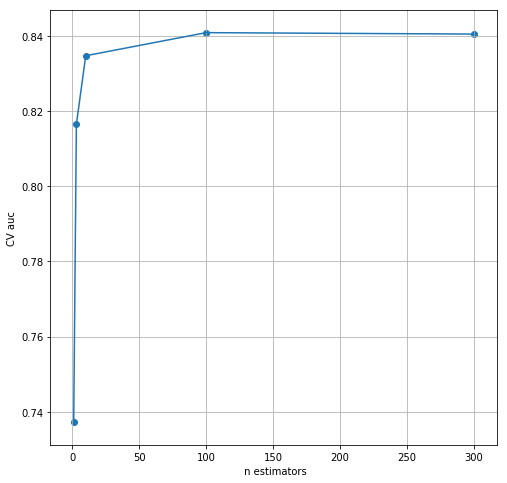

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold

n_estimators_list = [1, 3, 10, 100, 300 ]

x = np.array(train[features].copy())
y = np.array(train['stroke'].copy())
    
mean_auc_list = [ ]
for n in n_estimators_list:
    clf = RandomForestClassifier(n_estimators = n, max_depth = 3)
    
    print("n_estimators:", n)
    
    kf = KFold(n_splits=5)
    kf.get_n_splits(x)
    scores = []
    fold_number = 1
    
    auc_in_folds = []
    for train_index, test_index in kf.split(x):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        clf.fit(x_train, y_train)
        prediction = clf.predict_proba(x_test)[:,1]
        
        auc = roc_auc_score(y_test, prediction )
        auc_in_folds.append(auc)
        
    print('|'.join([str(el) for el in auc_in_folds]))
    print("average auc:",np.mean(auc_in_folds))
    mean_auc_list.append( np.mean(auc_in_folds))
    print('=============================')
    
    
# plot 
plt.figure(figsize=(8,8))
plt.plot(n_estimators_list, mean_auc_list )
plt.scatter(n_estimators_list, mean_auc_list )
plt.xlabel(' n estimators')
plt.ylabel('CV auc')
plt.grid(1)
plt.show()

#### Вывод
Прежде всего, при использовании 1 и 3 случайных деревьев налицо проблема переобучения: значения roc-auc в кросс-валидации сильно различаются между собой. Кроме того, при n_estimators>=100 roc-auc выходит на ассимтоту, что говорит о том, что не имеет смысла задавать количество деревьев более 100 - при прочих неизменных параметрах, точность результатов это не увеличит.

### min_samples_split

min_samples_split: 2
0.6615468476701958|0.6364285606387389|0.6044022061314362|0.6253522412712642|0.6164784244254443
average auc: 0.6288416560274159
min_samples_split: 4
0.7039627039627039|0.6809746239923196|0.641967663166215|0.6912844753766578|0.6809902107915353
average auc: 0.6798359354578862
min_samples_split: 8
0.7437121126548439|0.7365504138140546|0.7103570319557361|0.7262312362786721|0.74738977387984
average auc: 0.7328481137166293
min_samples_split: 15
0.780611948012829|0.7569851577461526|0.7465824723351399|0.7739714278204549|0.7508226514849031
average auc: 0.761794731479896
min_samples_split: 25
0.803032870213487|0.7830375680388857|0.7646413801377596|0.7747440414679797|0.7902173696875683
average auc: 0.7831346459091361
min_samples_split: 50
0.8083905815183349|0.8101994128892464|0.7937971078929538|0.82063604709554|0.8136134096398997
average auc: 0.8093273118071951


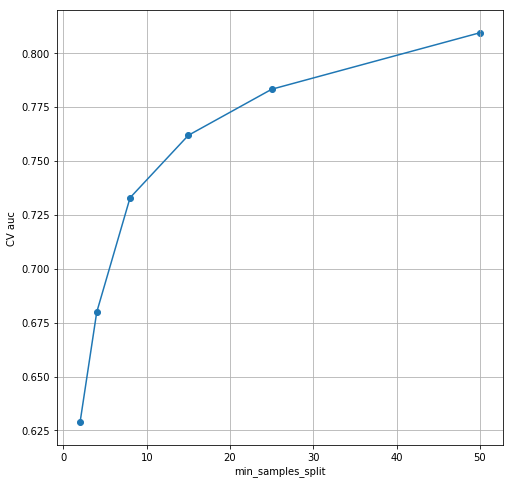

In [26]:
min_samples_split_list = [2,4,8,15,25,50]
name='min_samples_split'
x = np.array(train[features].copy())
y = np.array(train['stroke'].copy())
    
mean_auc_list = []
for n in min_samples_split_list:
    clf = RandomForestClassifier(min_samples_split=n)
    
    print("{}:".format(name), n)
    
    kf = KFold(n_splits=5)
    kf.get_n_splits(x)
    scores = []
    fold_number = 1
    
    auc_in_folds = []
    for train_index, test_index in kf.split(x):

        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        clf.fit(x_train, y_train)
        prediction = clf.predict_proba(x_test)[:,1]
        
        auc = roc_auc_score(y_test, prediction )
        auc_in_folds.append(auc)
        
    print('|'.join([str(el) for el in auc_in_folds]))
    print("average auc:",np.mean(auc_in_folds))
    mean_auc_list.append( np.mean(auc_in_folds))
    print('=============================')
    
    
# plot 
plt.figure(figsize=(8,8))
plt.plot(min_samples_split_list, mean_auc_list )
plt.scatter(min_samples_split_list, mean_auc_list )
plt.xlabel(name)
plt.ylabel('CV auc')
plt.grid(1)
plt.show()

#### Вывод
В данном случае мы варьировали минимальное число участников, которых достаточно для создания нового узла дерева.
При маленьком значении данного параметра во-первых точность алгоритма оставляет желать лучшего (roc_auc близок к 50%), во-вторых результаты кросс-валидации говорят о переобучении (разница в roc-auc около 5 процентов) Только при min_samples_split=50 достигается относительно хорошая точность алгоритма и удовлетворительные результаты кросс-валидации. Таким образом, маленькое значение min_samples_split приводит к созданию большого числа классов, снижая точность и становясь причиной переобучения. 

### max depth

max_depth: 2
0.8158217211080647|0.8405494134766928|0.8344325175022584|0.831419437216322|0.835995190299826
average auc: 0.8316436559206328
max_depth: 4
0.8385729542117206|0.8497353973403782|0.8354046691508582|0.8441796669115237|0.8344829801783443
average auc: 0.8404751335585651
max_depth: 8
0.833109132668604|0.8343644416992979|0.8200628458107497|0.8275480687425558|0.8147125729907188
average auc: 0.8259594123823852
max_depth: 20
0.6459281051792065|0.6640494529195249|0.6273351047312556|0.6125920115760627|0.672789702591027
average auc: 0.6445388753994153
max_depth: 80
0.6402880037241271|0.6308016629769436|0.6186598421973802|0.6311554897070155|0.6197307852936992
average auc: 0.6281271567798331


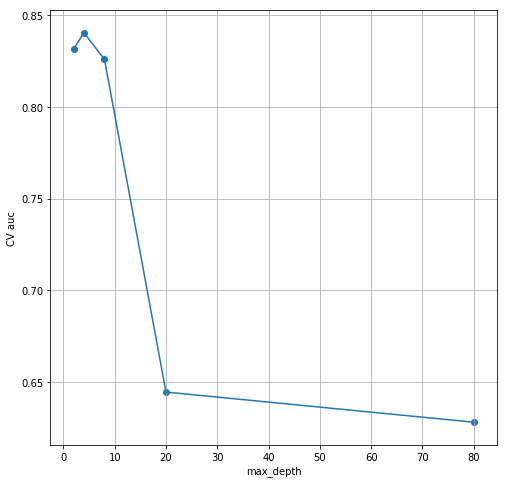

In [27]:
max_depth_list = [2,4,8,20,80]
name='max_depth'
x = np.array(train[features].copy())
y = np.array(train['stroke'].copy())
    
mean_auc_list = []
for n in max_depth_list:
    clf = RandomForestClassifier(max_depth=n)
    
    print("{}:".format(name), n)
    
    kf = KFold(n_splits=5)
    kf.get_n_splits(x)
    scores = []
    fold_number = 1
    
    auc_in_folds = []
    for train_index, test_index in kf.split(x):

        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        clf.fit(x_train, y_train)
        prediction = clf.predict_proba(x_test)[:,1]
        
        auc = roc_auc_score(y_test, prediction )
        auc_in_folds.append(auc)
        
    print('|'.join([str(el) for el in auc_in_folds]))
    print("average auc:",np.mean(auc_in_folds))
    mean_auc_list.append( np.mean(auc_in_folds))
    print('=============================')
    
    
# plot 
plt.figure(figsize=(8,8))
plt.plot(max_depth_list, mean_auc_list )
plt.scatter(max_depth_list, mean_auc_list )
plt.xlabel(name)
plt.ylabel('CV auc')
plt.grid(1)
plt.show()

#### Вывод
Оптимальную точность и результаты кросс-валидации обеспечивают значения высоты дерева в 4-8 слоев. При бОльших значениях резко падает точность алгоритма и наблюдается переобученность. Этот эффект можно исправить при увеличении числа случайных деревьев.

## Decision tree

### max depth

max_depth: 2
0.7970864182317927|0.7707884706083763|0.8042164210704608|0.7894527515974495|0.7822233848723914
average auc: 0.7887534892760941
max_depth: 4
0.8342395489972583|0.8298134102272747|0.8315328237917796|0.8400841920619309|0.80829352021405
average auc: 0.8287926990584588
max_depth: 8
0.7417088540436558|0.7939716246586517|0.7902260825993677|0.7211674005458788|0.7681094237385628
average auc: 0.7630366771172233
max_depth: 20
0.5490400446347582|0.521842097754444|0.530445460704607|0.5176698193730278|0.5574096766149746
average auc: 0.5352814198163622
max_depth: 80
0.5305768631759822|0.5281613430032612|0.5204945799457995|0.5263760753993452|0.5412289518249784
average auc: 0.5293675626698733


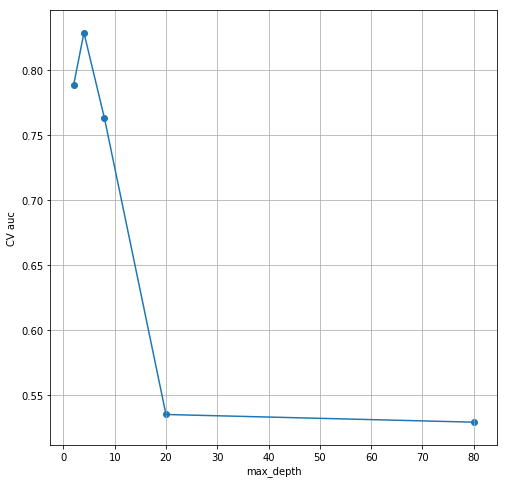

In [28]:
from sklearn.tree import DecisionTreeClassifier
max_depth_list = [2,4,8,20,80]
name='max_depth'
x = np.array(train[features].copy())
y = np.array(train['stroke'].copy())
    
mean_auc_list = []
for n in max_depth_list:
    clf = DecisionTreeClassifier(max_depth=n)
    
    print("{}:".format(name), n)
    
    kf = KFold(n_splits=5)
    kf.get_n_splits(x)
    scores = []
    fold_number = 1
    
    auc_in_folds = []
    for train_index, test_index in kf.split(x):

        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        clf.fit(x_train, y_train)
        prediction = clf.predict_proba(x_test)[:,1]
        
        auc = roc_auc_score(y_test, prediction )
        auc_in_folds.append(auc)
        
    print('|'.join([str(el) for el in auc_in_folds]))
    print("average auc:",np.mean(auc_in_folds))
    mean_auc_list.append( np.mean(auc_in_folds))
    print('=============================')
    
    
# plot 
plt.figure(figsize=(8,8))
plt.plot(max_depth_list, mean_auc_list )
plt.scatter(max_depth_list, mean_auc_list )
plt.xlabel(name)
plt.ylabel('CV auc')
plt.grid(1)
plt.show()

#### Вывод
При варьировании максимальной высоты дерева мы получили примерно те же закономерности, что и для случайного леса:
начиная со значения 4, точность падает и при высоких значениях наблюдается переобученность. Стоит так же отметить, что при одних и тех же значениях максимальной высоты метод случайных деревьев дает более точные результаты, чем метод решающего дерева, что естественно. 

### min_sampes_split

min_samples_split: 5
0.5573568624229417|0.5444797658270659|0.5352700499661247|0.5367237031226871|0.5866388548507753
average auc: 0.5520938472379189
min_samples_split: 10
0.5686627371649399|0.5636271628519014|0.5628281673441734|0.5532639986940963|0.5975838293719089
average auc: 0.5691931790854039
min_samples_split: 30
0.615664438351663|0.6116332857221983|0.5891194882000903|0.6023543619815983|0.6777279062047274
average auc: 0.6192998960920555
min_samples_split: 50
0.6282530489578947|0.6234955077131717|0.6158580693879855|0.6285180896729846|0.6910884394328103
average auc: 0.6374426310329694
min_samples_split: 150
0.7294377184245024|0.7235284047136703|0.7250072337962963|0.7171632282938449|0.7565288161314652
average auc: 0.7303330802719559


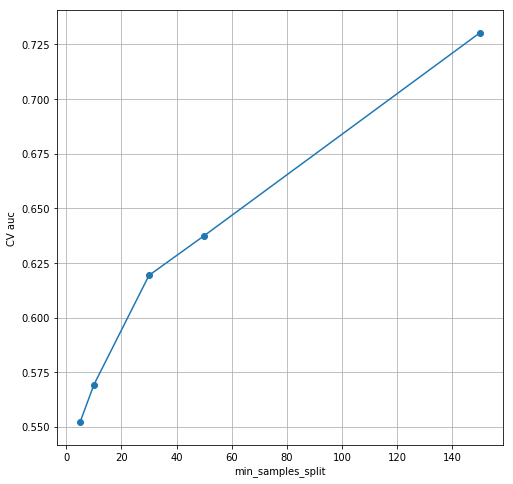

In [37]:
min_samples_split_list = [5,10,30,50,150]
name='min_samples_split'
x = np.array(train[features].copy())
y = np.array(train['stroke'].copy())
    
mean_auc_list = []
for n in min_samples_split_list:
    clf = DecisionTreeClassifier(min_samples_split=n)
    
    print("{}:".format(name), n)
    
    kf = KFold(n_splits=5)
    kf.get_n_splits(x)
    scores = []
    fold_number = 1
    
    auc_in_folds = []
    for train_index, test_index in kf.split(x):

        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        clf.fit(x_train, y_train)
        prediction = clf.predict_proba(x_test)[:,1]
        
        auc = roc_auc_score(y_test, prediction )
        auc_in_folds.append(auc)
        
    print('|'.join([str(el) for el in auc_in_folds]))
    print("average auc:",np.mean(auc_in_folds))
    mean_auc_list.append( np.mean(auc_in_folds))
    print('=============================')
    
    
# plot 
plt.figure(figsize=(8,8))
plt.plot(min_samples_split_list, mean_auc_list )
plt.scatter(min_samples_split_list, mean_auc_list )
plt.xlabel(name)
plt.ylabel('CV auc')
plt.grid(1)
plt.show()

#### Вывод 
В данном случае варьировалось минимальное число объектов для создания нового узла. Закономерность та же, что и для 
метода случайного леса. Отличие состоит в том, что 50 объектов недостаточно для приемлемой точности и избежания переобученности. Кроме того результаты в целом хуже, чем у метода случайного леса. 

### min_samples_leaf

min_samples_leaf: 5
0.6230305426340669|0.6446167247679168|0.6245192171973803|0.6122855945251641|0.6863927095715175
average auc: 0.6381689577392091
min_samples_leaf: 10
0.621122269800684|0.626549389978835|0.6673565238256549|0.6069955773575091|0.6988292418755995
average auc: 0.6441706005676565
min_samples_leaf: 30
0.7032695645030447|0.7090738655150478|0.6991569980803973|0.6643529758421626|0.7186922021359108
average auc: 0.6989091212153127
min_samples_leaf: 50
0.7115418844493734|0.7572209755303383|0.7193992773261065|0.6844637563272008|0.7383218674609403
average auc: 0.722189552218792
min_samples_leaf: 150
0.7973516938274647|0.8097378478312317|0.7787860984078592|0.7550655649486562|0.8043198572999898
average auc: 0.7890522124630402


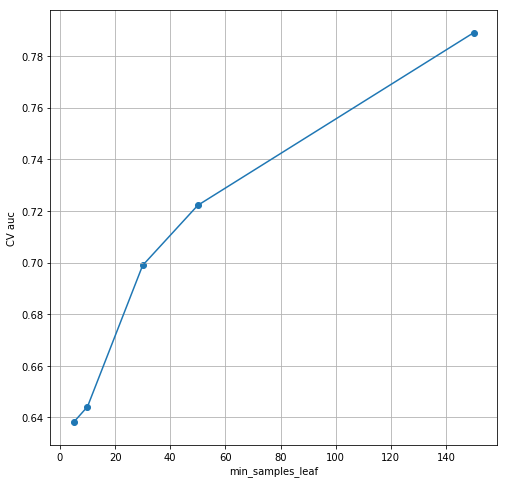

In [38]:
min_samples_leaf_list = [5,10,30,50,150]
name='min_samples_leaf'
x = np.array(train[features].copy())
y = np.array(train['stroke'].copy())
    
mean_auc_list = []
for n in min_samples_leaf_list:
    clf = DecisionTreeClassifier(min_samples_leaf=n,min_samples_split=50)
    
    print("{}:".format(name), n)
    
    kf = KFold(n_splits=5)
    kf.get_n_splits(x)
    scores = []
    
    auc_in_folds = []
    for train_index, test_index in kf.split(x):

        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        clf.fit(x_train, y_train)
        prediction = clf.predict_proba(x_test)[:,1]
        
        auc = roc_auc_score(y_test, prediction )
        auc_in_folds.append(auc)
        
    print('|'.join([str(el) for el in auc_in_folds]))
    print("average auc:",np.mean(auc_in_folds))
    mean_auc_list.append( np.mean(auc_in_folds))
    print('=============================')
    
    
# plot 
plt.figure(figsize=(8,8))
plt.plot(min_samples_leaf_list, mean_auc_list )
plt.scatter(min_samples_leaf_list, mean_auc_list )
plt.xlabel(name)
plt.ylabel('CV auc')
plt.grid(1)
plt.show()

### Вывод
min_samples_leaf - Минимальное количество объектов, которые должны оказаться и в левой и в правой ветви для создания узла.. 
По-видимому, данный параметр должен ограничивать высоту дерева, предотвращая переобучение. Дополняет параметр min_samples_split. Принцип работы и задачи у этих параметров похожи, предполагаю, что они взаимозаменяемы. Однако одновременное их позволяет уменьшить эффект переобучения.
В рассмотренном случае видим, что при малых значениях min_samples_leaf точность модели низкая. При всех параметрах наблюдается эффект переобучения. 

## Logistic Regression

### max_iter

max_iter: 10
0.6702025336386568|0.6406640494529194|0.672750112917796|0.6689713655686838|0.6617682379271785
average auc: 0.662871259901047
max_iter: 20
0.8419453771876679|0.8415321274456654|0.8471728206865403|0.8511145142079293|0.839896952479734
average auc: 0.8443323584015074
max_iter: 50
0.842511868943587|0.8439104463082349|0.8478309197154472|0.8514811079708552|0.8427943990857899
average auc: 0.8457057484047829
max_iter: 100
0.842511868943587|0.8439104463082349|0.8478309197154472|0.8514811079708552|0.8427943990857899
average auc: 0.8457057484047829
max_iter: 500
0.842511868943587|0.8439104463082349|0.8478309197154472|0.8514811079708552|0.8427943990857899
average auc: 0.8457057484047829
max_iter: 1000
0.842511868943587|0.8439104463082349|0.8478309197154472|0.8514811079708552|0.8427943990857899
average auc: 0.8457057484047829


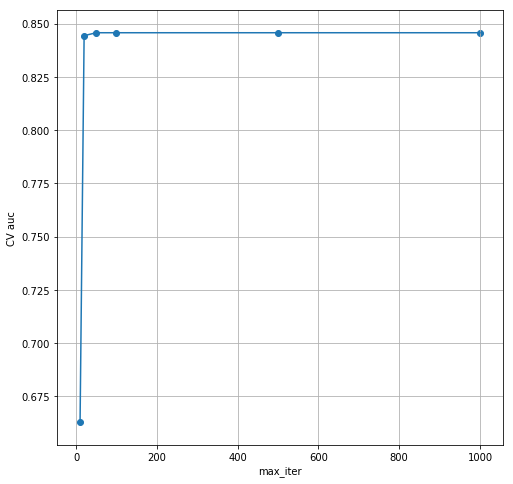

In [72]:
from sklearn.linear_model import LogisticRegression
max_iter_list = [10,20,50,100,500,1000]
name='max_iter'
x = np.array(train[features].copy())
y = np.array(train['stroke'].copy())
    
mean_auc_list = []
for n in max_iter_list:
    clf = LogisticRegression(max_iter=n)
    
    print("{}:".format(name), n)
    
    kf = KFold(n_splits=5)
    kf.get_n_splits(X)
    scores = []
    fold_number = 1
    
    auc_in_folds = []
    for train_index, test_index in kf.split(X):

        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        clf.fit(x_train, y_train)
        prediction = clf.predict_proba(x_test)[:,1]
        
        auc = roc_auc_score(y_test, prediction )
        auc_in_folds.append(auc)
        
    print('|'.join([str(el) for el in auc_in_folds]))
    print("average auc:",np.mean(auc_in_folds))
    mean_auc_list.append( np.mean(auc_in_folds))
    print('=============================')
    
    
# plot 
plt.figure(figsize=(8,8))
plt.plot(max_iter_list, mean_auc_list )
plt.scatter(max_iter_list, mean_auc_list )
plt.xlabel(name)
plt.ylabel('CV auc')
plt.grid(1)
plt.show()

#### Вывод
max_iter - максимальное количество итераций, необходимое для сходимости модели. 
В данном случае примерно 30 итераций хватает алгоритму, для того чтобы сойтись.

### solver

solver: newton-cg
0.8429962108376206|0.8461561701177747|0.8475151027551941|0.8498943794950965|0.8443134933201158
average auc: 0.8461750713051603
solver: lbfgs
0.8422876682788577|0.840993355141583|0.847118126129178|0.8524577690901973|0.8427546242115778
average auc: 0.8451223085702788
solver: liblinear
0.842511868943587|0.8439104463082349|0.8478309197154472|0.8514811079708552|0.8427943990857899
average auc: 0.8457057484047829
solver: sag


/home/gatupov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/gatupov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/gatupov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/gatupov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/gatupov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_ite

0.6974198097546115|0.6705936062329746|0.706764834575429|0.7003006068855994|0.6874903431194821
average auc: 0.6925138401136193
solver: saga


/home/gatupov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/gatupov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/gatupov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/gatupov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.6812157494976878|0.653279042093055|0.6874894139566397|0.6808559203509339|0.6722749239305532
average auc: 0.6750230099657739


/home/gatupov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


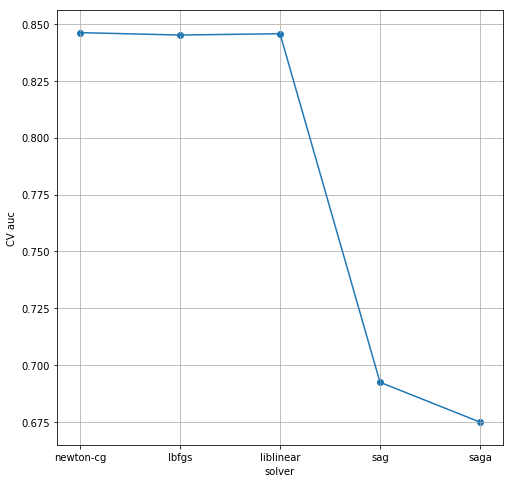

In [40]:
from sklearn.linear_model import LogisticRegression
solver_list = ['newton-cg','lbfgs', 'liblinear', 'sag', 'saga']
name='solver'
x = np.array(train[features].copy())
y = np.array(train['stroke'].copy())
    
mean_auc_list = []
for n in solver_list:
    clf = LogisticRegression(solver=n)
    
    print("{}:".format(name), n)
    
    kf = KFold(n_splits=5)
    kf.get_n_splits(x)
    scores = []
    fold_number = 1
    
    auc_in_folds = []
    for train_index, test_index in kf.split(x):

        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        clf.fit(x_train, y_train)
        prediction = clf.predict_proba(x_test)[:,1]
        
        auc = roc_auc_score(y_test, prediction )
        auc_in_folds.append(auc)
        
    print('|'.join([str(el) for el in auc_in_folds]))
    print("average auc:",np.mean(auc_in_folds))
    mean_auc_list.append( np.mean(auc_in_folds))
    print('=============================')
    
    
# plot 
plt.figure(figsize=(8,8))
plt.plot(solver_list, mean_auc_list )
plt.scatter(solver_list, mean_auc_list )
plt.xlabel(name)
plt.ylabel('CV auc')
plt.grid(1)
plt.show()

#### Вывод
В данном случае использованы различные алгоритмы для вычисления коэффициентов регрессии.
На нашем датасете не работают алгоритмы 'sag' и 'saga'

### tolerance

tol: 0.0001
0.9991853472029684|0.9999949647448216|1.0|1.0|1.0
average auc: 0.999836062389558
tol: 0.001
0.6462952123745076|0.6471595286329785|0.6833696787488709|0.5757154457710989|0.670050590580392
average auc: 0.6445180912215696
tol: 0.01
0.348803179199655|0.3782450121601413|0.37869629347335143|0.32712752344470863|0.33508189799580523
average auc: 0.3535907812547323
tol: 0.1
0.5042957531944317|0.46548416496167333|0.48098393744354107|0.5129407598312838|0.4516482860853722
average auc: 0.4830705803032604
tol: 0.5
0.5042974646498877|0.46548416496167333|0.48098923046522135|0.5129407598312838|0.4516482860853722
average auc: 0.4830719811986877


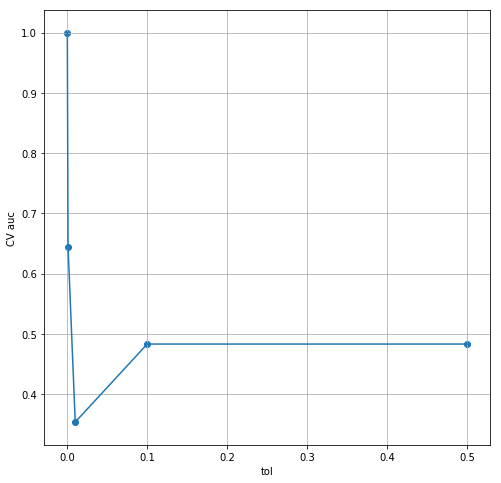

In [90]:
from sklearn.linear_model import LogisticRegression
tol_list = [1e-4,1e-3,1e-2,1e-1,0.5]
name='tol'
x = np.array(train[features].copy())
y = np.array(train['stroke'].copy())

mean_auc_list = []
for n in tol_list:
    clf = LogisticRegression(tol=n)
    
    print("{}:".format(name), n)
    
    kf = KFold(n_splits=5)
    kf.get_n_splits(x)
    scores = []
    
    auc_in_folds = []
    for train_index, test_index in kf.split(x):

        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        clf.fit(x_train, y_train)
        prediction = clf.predict_proba(x_test)[:,1]
        
        auc = roc_auc_score(y_test, prediction )
        auc_in_folds.append(auc)
        
    print('|'.join([str(el) for el in auc_in_folds]))
    print("average auc:",np.mean(auc_in_folds))
    mean_auc_list.append( np.mean(auc_in_folds))
    print('=============================')
    
    
# plot 
plt.figure(figsize=(8,8))
plt.plot(tol_list, mean_auc_list )
plt.scatter(tol_list, mean_auc_list )
plt.xlabel(name)
plt.ylabel('CV auc')
plt.grid(1)
plt.show()

#### вывод
Было проверены различные критерии остановки для поиска максимума функции правдоподобия. Из наших результатов видно, что оптимальный критерий лежит в интервале $10^{-4}-10^{-3}$

## Submiting

### Decision Tree

In [110]:
features = ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', \
        'Residence_type', 'avg_glucose_level', 'bmi', \
       'Govt_job','Never_worked','Private','Self-employed','children',\
           'formerly smoked','never smoked','smokes']

clf = DecisionTreeClassifier(max_depth=3)
x = np.array(train[features].copy())
y = np.array(train['stroke'].copy())
kf = KFold(n_splits=5)
kf.get_n_splits(x)
auc_in_folds = []
for train_index, test_index in kf.split(x):
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf.fit(x_train, y_train)
    prediction = clf.predict_proba(x_test)[:,1]    
    auc = roc_auc_score(y_test, prediction )
    auc_in_folds.append(auc)
        
print('Decision Tree')
print('roc-auc:')
print('|'.join([str(el) for el in auc_in_folds]))
print("average auc:",np.mean(auc_in_folds))
mean_auc_list.append( np.mean(auc_in_folds))
print('=============================')
output = pd.DataFrame()
output['id'] = test['id'].copy()
prediction = clf.predict(test[features])
print(prediction)
output['stroke'] = prediction
output.to_csv('submission_decision_tree.csv',index=None) 

Decision Tree
roc-auc:
0.825849994352197|0.8175139602449819|0.8307979759485096|0.8295138413354526|0.8144639800268939
average auc: 0.8236279503816071
[0 0 0 ... 0 0 0]


### Random Forest

In [111]:


clf = RandomForestClassifier(n_estimators=3)
x = np.array(train[features].copy())
y = np.array(train['stroke'].copy())
kf = KFold(n_splits=5)
kf.get_n_splits(x)
auc_in_folds = []
for train_index, test_index in kf.split(x):
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf.fit(x_train, y_train)
    prediction = clf.predict_proba(x_test)[:,1]    
    auc = roc_auc_score(y_test, prediction )
    auc_in_folds.append(auc)
        
print('Random Forest')
print('roc-auc:')
print('|'.join([str(el) for el in auc_in_folds]))
print("average auc:",np.mean(auc_in_folds))
mean_auc_list.append( np.mean(auc_in_folds))
print('=============================')
output = pd.DataFrame()
output['id'] = test['id'].copy()
prediction = clf.predict(test[features])
print(prediction)
output['stroke'] = prediction
output.to_csv('submission_random_forest.csv',index=None)

Random Forest
roc-auc:
0.5544850401678595|0.5560172138590364|0.5527290819783198|0.5505809473612857|0.5747308694328562
average auc: 0.5577086305598715
[0 0 0 ... 0 0 0]


### Logistic Regression

In [113]:
clf = LogisticRegression()
x = np.array(train[features].copy())
y = np.array(train['stroke'].copy())
kf = KFold(n_splits=5)
kf.get_n_splits(x)
auc_in_folds = []
for train_index, test_index in kf.split(x):
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf.fit(x_train, y_train)
    prediction = clf.predict_proba(x_test)[:,1]    
    auc = roc_auc_score(y_test, prediction )
    auc_in_folds.append(auc)
        
print('Logistic Regression')
print('roc-auc:')
print('|'.join([str(el) for el in auc_in_folds]))
print("average auc:",np.mean(auc_in_folds))
mean_auc_list.append( np.mean(auc_in_folds))
print('=============================')
output = pd.DataFrame()
output['id'] = test['id'].copy()
prediction = clf.predict(test[features])
print(set(prediction))
output['stroke'] = prediction
output.to_csv('submission_logistic_regression.csv',index=None)

Logistic Regression
roc-auc:
0.842511868943587|0.8439104463082349|0.8478309197154472|0.8514811079708552|0.8427943990857899
average auc: 0.8457057484047829
{0}
